# Statistical Modeling

In this notebook, I lay out some of the basic principles behind a set of techniques usually named by umbrella terms---statistical modeling, machine learning, even "artificial intelligence." In a nutshell, these approaches take a large dataset and attempt to determine values or categories from that data. I'll show a few of the most basic versions of this approach and gesture to more complex methods. 

Modeling, writ large, has become a massive field in data science. Ted Underwood uses models to understand literary history in *Distant Horizons*, the OCR tool [Ocular](https://github.com/tberg12/ocular) uses statistical models of both typefaces and language, and, of course, topic modeling---technically [Latent Dirichlet Allocation (LDA)](http://mallet.cs.umass.edu/)---was one of the earliest types of modeling to be widely adopted by humanities scholars. 

But statistical models are also often what is underneath the vague talk of "algorithms" or "machine learning" that make up so much discussion of contemporary technology. Models help to deliver search results, determine what social media posts you see, and [even try to predict who will be elected president](https://projects.fivethirtyeight.com/2020-election-forecast/). Understanding how statistical modeling works can help you to critique the technologies that increasingly determine so much of our lives, and it can help you to better understand the recent achievements of statistical models in the humanities (and even use these techniques in your own work).

We'll begin, as always, by `import`ing necessary libraries and functions. We'll use many of the ones we've used before, including a few new ones from [scikit-learn](https://scikit-learn.org/stable/index.html).

In [1]:
# General Libraries Needed
import glob, csv
import pandas as pd
from collections import defaultdict, Counter
from lxml import etree

# Functions for Unsupervised Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Functions for Supervised Classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

# Libraries for Graphing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Reading a Text Corpus

You can create a statistical model from any kind of data, but in this exercise we'll use data derived from a set of texts, the same corpus of 1666 texts we've been using all along. Here we're borrowing techniques from the field of *information retrieval* to get features from our texts, the same way we did in the [Tf-Idf](https://earlyprint.org/jupyterbook/tf_idf.html) and [Text Similarity](https://earlyprint.org/jupyterbook/similarity.html) tutorials.

In previous tutorials, we extracted lists of words from the XML files and converted them to Tf-Idf values using `TfidfTransformer`. That would still work in this case, but in order to place some additional limits on Tf-Idf, we'll convert the text from our XML back into strings. We can put those strings into `TfIdfVectorizer`, which will give us access to those additional limits (see below). The next code block extracts all the lemmas from our texts and converts them into strings.

In [2]:
# Use the glob library to create a list of file names
filenames = glob.glob("1666_texts/*.xml")
# Parse those filenames to create a list of file keys (ID numbers)
# You'll use these later on.

filekeys = [f.split('/')[-1].split('.')[0] for f in filenames]
# Create an empty lists to put all our texts into
all_tokenized = []
all_strings = []

nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}
parser = etree.XMLParser(collect_ids=False) # Create a parse object that skips XML IDs (in this case they just slow things down)

# Then you can loop through the files
for f in filenames:
    tree = etree.parse(f, parser) # Parse each file into an XML tree
    xml = tree.getroot() # Get the XML from that tree
    # Now we can use lxml to find all the w tags
    # In this next line you'll do several things at once to create a list of words for each text
    # 1. Loop through each word: for word in word_tags
    # 2. Make sure the tag has a word at all: if word.text != None
    # 3. Get the lemmatized form of the word: word.get('reg', word.text)
    # 4. Make sure all the words are in lowercase: .lower()
    words = [word.get('lemma', word.text).lower() for word in xml.iter("{*}w") if word.text != None]
    full_string = ' '.join(words)
    # Then we add these results to a master list
    all_strings.append(full_string)

Now that we have strings for each text, we can "vectorize" them into Tf-Idf values. Scikit-learn provides [many options and parameters](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) for its `TfidfVectorizer` that aren't available in the `TfidfTransformer` we used in previous tutorials. Specifically, we want to use the `min_df` parameter to set the minimum document frequency to 2: this will filter out all words that appear in fewer than two texts. This creates a smaller list of features and will allow our models to run more quickly and more accurately.

In [33]:
# First we need to create an "instance" of the vectorizer, with the proper settings.
# Normalization is set to 'l2' by default
tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)
# I am choosing to turn on sublinear term frequency scaling, which takes the log of
# term frequencies and can help to de-emphasize function words like pronouns and articles. 
# You might make a different choice depending on your corpus.

# Once we've created the instance, we can "transform" our counts
results = tfidf.fit_transform(all_strings)

# Make results readable using Pandas
readable_results = pd.DataFrame(results.toarray(), index=filekeys, columns=tfidf.get_feature_names()) # Convert information back to a DataFrame
readable_results

,00,01,02,03,04,05,06,07,09,10,...,zoilus,zonar,zonara,zonaras,zone,zophar,zosimus,zum,àd,ùs
B02845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A51130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A28171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A51877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A60948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A53818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A57156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A65985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Unsupervised Clustering

Now that we have our matrix of word counts, there are many, many methods and techniques we could apply to categorize or *classify* our texts. There are two general types of modeling I will introduce: *unsupervised* methods and *supervised* ones. Supervised methods are so called because the investigator provides some labels for the data, telling which samples belong in which categories. And based on those samples---the *training data*---the computer tries to determine to which categories the unlabeled samples belong.

The supervised methods are what's most often meant by "machine learning" (because the machine "learns" based on the training data). But there are a set of *unsupervised* methods which try to find categories in data without knowing about categories in advance. We'll work with one such *clustering* method, K-Means Clustering. The k-means method attempts to find categories in data based on how close the samples are to one another in Cartesian space, i.e. in the graph above but across thousands of dimensions. 

The *k* in k-means stands for *any number*: we need to tell the computer how many clusters we think it should find. As a test we'll set `n_clusters` to 4, placing our texts into 4 groups.

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42) # Create a KMeans instance that will look for 4 clusters
kmeans.fit(readable_results) # Feed in our normalized data

# Show which plays the model put together
kmeans_groups = defaultdict(list)
for k,v in zip(kmeans.labels_,filekeys):
    kmeans_groups[k].append(v)
    
for v in kmeans_groups.values():
    print(v)

['B02845', 'A51130', 'A36358', 'A35206', 'A39345', 'A61929', 'B03114', 'A32916', 'A70852', 'B01661', 'A32751', 'A92820', 'A39246', 'A87622', 'A26426', 'A55410', 'A31237', 'B05835', 'A80818', 'A59325', 'B06022', 'A60606', 'A52519', 'A64258', 'A35851', 'B02572', 'B03376', 'B01318', 'B03106', 'A44879', 'A54070', 'A70287', 'A28209', 'B04153', 'B03109', 'A42533', 'A42537', 'A44627', 'A93280', 'A38792', 'B06375', 'A41072', 'B04338', 'B03631', 'A41266', 'A93281', 'A67335', 'A40254', 'B06872', 'B04364', 'A41958', 'A96485', 'A59614', 'A38630']
['A28171', 'A60482', 'A25743', 'A61594', 'A64861', 'A61503', 'A62436', 'A38556', 'A57484', 'A66752', 'A26249', 'A61867', 'A61891', 'A28989', 'A65296', 'A30203', 'A56381', 'A61600', 'A66777', 'A39714', 'A44801', 'A43020', 'A45206', 'A23770', 'A44938', 'A56390', 'A59229', 'A30143', 'A47095', 'A29017', 'A47367', 'A67572', 'A44478', 'A47379', 'A39839', 'A48797', 'A25198', 'A42820', 'A67762', 'A45552', 'A97379', 'A26482', 'A36329', 'A41527', 'A31229', 'A53049'

We can see in the list above that `KMeans` has produced four groups as intended: three of them are of somewhat similar size and one is a bit smaller. But we can't tell much from the lists of file IDs above. Do these groups correspond to any known genres or categories of texts?

We could list out the title of every text in each group and try to discern groupings that way, but we could also look at the [Library of Congress subject headings](https://id.loc.gov/authorities/subjects.html) assigned to many of the texts. We can retrieve these from the [*EarlyPrint* metadata](https://earlyprint.org/jupyterbook/metadata.html), count them up, and look at the most common subject headings in each group.

[n.b. The subject headings in the *EarlyPrint* corpus are a helpful but imperfect data set. Most of them were assigned by the British Library to the original EEBO texts, in some cases many years ago. Not every text has subject headings, and the subject headings may not account for every possible subject, genre, or category that a researcher may care about.]

In [34]:
parser = etree.XMLParser(collect_ids=False, encoding='utf-8')
nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}

# Get the full list of metadata files
# (You'll change this line based on where the files are on your computer)
metadata_files = glob.glob("../../epmetadata/header/*.xml")

for k,v in kmeans_groups.items(): # Loop through each file
    print(f'Group {k+1}')
    all_keywords = []
    for filekey in v:
        filename = f'../../epmetadata/header/{filekey}_header.xml' # Get TCP ID from filename
        metadata = etree.parse(filename, parser) # Create lxml tree for metadata
        keywords = [k.text.strip(".") for k in metadata.findall(".//tei:item", namespaces=nsmap)]
        all_keywords.extend(keywords)
    print(Counter(all_keywords))
    print()

Group 3
Counter({'Great Britain': 54, 'England': 54, 'London': 49, 'Poetry': 28, 'Broadside poems': 14, 'History': 11, '17th century': 9, 'Charles II, 1660-1685': 7, 'Anglo-Dutch War, 1664-1667': 6, 'Ballads, English': 6, 'Controversial literature': 5, 'Foreign relations': 4, 'Netherlands': 4, 'Great Fire, London, England, 1666': 3, 'Christian life': 3, 'Oxford': 3, 'Dissenters, Religious': 3, 'Restoration, 1660-1688': 2, 'Conduct of life': 2, 'Scotland': 2, 'Edinburgh': 2, 'Loyalty oaths': 2, 'Quakers': 2, '1648-1714': 1, 'Monarchy': 1, 'Apologetic works': 1, 'Early works to 1900': 1, 'Jews': 1, 'Migrations': 1, 'Restoration': 1, '70-1789': 1, 'Mehmed IV, 1648-1687': 1, 'Turkey': 1, 'Drinking of alcoholic beverages': 1, 'Presbyterian Church': 1, 'Sermons, English': 1, 'Sermons': 1, 'Description and travel': 1, '1600-1799': 1, 'France': 1, 'Paris (France)': 1, 'Royalists': 1, 'Catholics': 1, 'Commonwealth and Protectorate, 1649-1660': 1, 'God': 1, 'Meditation': 1, 'Harvesting': 1, 'Wra

How do we make sense of the lists above? There are some subject headings ("Great Britain," "England," "London") that are assigned to almost every text, and keep in mind that any individual text can have between 3 and ~12 terms assigned to it. (Remember: library cataloguers were originally accounting for these EEBO texts as part of much larger library collections.) 

But beyond those most common terms we see some patterns emerge. Group 3 appears to contain mostly poetry, broadsides, and ballads. Group 1 seems to have lots of sermons and religious texts---in addition to the "Sermons" and "Sermons, English" terms, there are lots of religion-related keywords like "Puritans," "Religious thought," and even "Hell." Group 4 seems to contain texts about politics and current events, with the "History" keyword appearing frequently as well as "Ireland," "Foreign relations," and the Great Fire of London. Group 2, the smallest group, may be less internally coherent, but perhaps "royal supremacy" is a clue that it contains royal proclamations and government documents, a common genre in the corpus.

We would be able to find out more by examining the texts in these groups individually, but as a first attempt, the subject headings seem to suggest that these groups are fairly thematically coherent. Not bad for an initial attempt at unsupervised clustering!

It can also be useful to visualize the clusters, to get a sense of how distinct they are from each other. As we did in the [Word Embeddings tutorial](https://earlyprint.org/jupyterbook/word2vec.html), we can project the high dimensional vector space of Tf-Idf (i.e. thousands of words) into just two graphable dimensions, using PCA. Let's create a DataFrame of our PCA results for each texts, with an additional "color" column for the K-Means clusters.

In [21]:
# Calculate PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(readable_results)

# Put PCA into a DataFrame
pca_df = pd.DataFrame(pca_results, index=filekeys, columns=["pc1","pc2"])

# Add "color" column for K-Means groups
pca_df['color'] = pd.Series(kmeans.labels_, index=filekeys)
pca_df

,pc1,pc2,color
B02845,-0.172944,-0.170989,2
A51130,0.129717,-0.132892,2
A36358,0.080575,-0.135456,2
A28171,0.423339,0.056677,0
A51877,-0.241586,0.135355,3
...,...,...,...
A60948,0.140028,0.002910,0
A53818,-0.266444,0.100981,3
A57156,0.196382,-0.026820,0
A65985,0.268681,-0.176699,0


Now that we've calculated PCA, we can graph our texts in two dimensions:

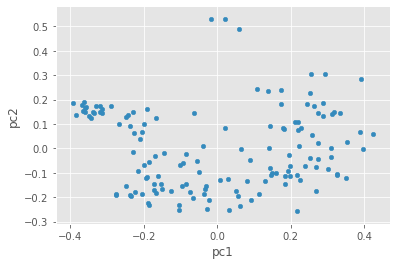

In [22]:
pca_df.plot.scatter(x='pc1', y='pc2')

Do you notice any clusters in the data? If you had to draw circles around 4 distinct groups of texts, how would you divide them?

Let's use the "color" column to see what `KMeans` did with this data:

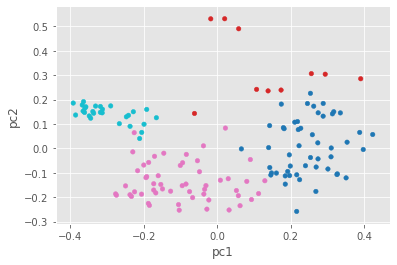

In [23]:
pca_df.plot.scatter(x='pc1', y='pc2', c='color', colormap='tab10', colorbar=False)

In the graph above, we can see how K-means divided our texts. We can't see all the variance using PCA, but this gives us a decent initial sense. We can see now why Group 2 (in red) isn't all that internally coherent---its texts aren't too close together. Some of the groups have closer, more "clustered" dots than others. So how did our unsupervised clustering method do? I think we might categorize this effort as *good* but not *great*. The next question is: would the computer do a better job if we tried to teach it about the genres we already know? To answer that, we'll need a *supervised classification* method.

## Targets

Before we can begin using a supervised method, we need to add one more piece of data to our matrix. In addition to *samples* and *features*, matrices can also have *targets*, i.e. category labels that particular samples fall into. These targets can be used to *train* a model by telling it what to expect.

In this case, we need targets that label the genre of a text. Rather than assigning genre labels ourselves, we can pull targets from the [metadata](https://earlyprint.org/jupyterbook/metadata.html). The supervised classification method we'll use can handle multiple categories at once, so let's choose a couple different generic categories. We'll use two of the most common genres in *EarlyPrint*: sermons and poetry. We'll also have a third "neither" category for texts that don't belong to either group.

In [56]:
targets = []

for filekey in filekeys:
    filename = f'../../epmetadata/header/{filekey}_header.xml' # Get TCP ID from filename
    metadata = etree.parse(filename, parser) # Create lxml tree for metadata
    # Find all the keywords in each text
    keywords = [k.text.lower().strip('.') for k in metadata.findall(".//tei:item", namespaces=nsmap)]
    # Search in those keywords for the word "sermon" or words pertaining to poetry
    poetry_terms = ['poetry', 'broadside poems', 'broadsides']
    if any('sermon' in k for k in keywords):
        targets.append('sermon')
    elif any(k in poetry_terms for k in keywords):
        targets.append('poetry')
    else:
        targets.append('neither')

print(targets)
print(Counter(targets))

['poetry', 'poetry', 'neither', 'sermon', 'neither', 'neither', 'neither', 'poetry', 'neither', 'poetry', 'poetry', 'neither', 'poetry', 'neither', 'poetry', 'neither', 'neither', 'poetry', 'neither', 'poetry', 'neither', 'sermon', 'poetry', 'neither', 'sermon', 'neither', 'neither', 'neither', 'poetry', 'poetry', 'poetry', 'poetry', 'sermon', 'poetry', 'neither', 'neither', 'neither', 'neither', 'neither', 'poetry', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'poetry', 'neither', 'sermon', 'poetry', 'neither', 'neither', 'neither', 'neither', 'neither', 'sermon', 'poetry', 'poetry', 'sermon', 'poetry', 'sermon', 'neither', 'neither', 'neither', 'neither', 'poetry', 'neither', 'neither', 'neither', 'neither', 'neither', 'poetry', 'poetry', 'neither', 'neither', 'poetry', 'poetry', 'neither', 'neither', 'neither', 'poetry', 'neither', 'neither', 'sermon', 'sermon', 'poetry', 'neither', 'poetry', 'neither', 'poetry', 'neither', 'neither', 'poetry', 'sermo

We can see that `targets` is simply a list of labels for each text in our corpus. If we count those up, we can see that 39 of our texts contain poetry, 15 of our texts are sermons, and 88 are neither. (The actual counts of poetry and sermons in this corpus are probably larger, but this is what we can find using the existing subject headings.)

## Supervised Classification

Now that we have target labels, we can use them to train a *supervised model* to determine genre categories. Unlike with K-means clustering, where we simply create a model and plug in the entire dataset, we need to split our data into a *training set*, which we use to help our model learn, and a *test set*, which we use to see how the model did. In our case, we'll split our data approximately in half, using just over half of the plays for training and reserving the rest for testing. 

We need to split both the feature set (denoted by a capital X) and the target labels (denoted by a lowercase y). Luckily, scikit-learn does all of this for us with its `train_test_split()` function.

Once the data is split, we can choose a model to train. In this case, the method I've chosen is logistic regression. Logistic regression is quite an old method for classification, and it is useful in part because it is easy to explain and provides results that (as we shall see) are easier to interpret than newer methods, like neural networks. Logistic regression uses a logistic function to draw an s-shaped [sigmoid curve](https://en.wikipedia.org/wiki/Sigmoid_function) that takes any value and converts it to a value between 0 and 1. The closer the value is to 0 or 1, the more closely it belongs in one category or another. Because of this 0-or-1, one-or-the-other feature, logistic regression was originally only a *binary* classifier: it could only tell if something was in one of just two categories. However, we can use multiclass logistic regression, and the model will predict all three of our classes at once.

In the code below, we'll split the data automatically, create a logistic regression model, and "fit" that model using the training data. Then, we'll run the model to *predict* categories for the texts in the test set. In the end, we can get accuracy scores, as well as a list of the texts in the test set with their real and predicted genres.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(readable_results, targets, test_size=0.45, random_state=2)
lr = LogisticRegression(random_state=0, solver='lbfgs', penalty='none')
clf = lr.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# evaluate accuracy
print("Accuracy score:", accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print("Cross validation score:", np.mean(cross_val_score(lr, readable_results, targets, cv=2)))
print()
print("Results of this run:\n")
print("Play Title | Actual Genre | Predicted Genre")
for title, real, predicted in zip(X_test.index, y_test, y_pred):
    print(f"{title} | {real} | {predicted}")

Accuracy score: 0.734375
Cross validation score: 0.7676056338028169

Results of this run:

Play Title | Actual Genre | Predicted Genre
A59614 | neither | neither
A32557 | neither | poetry
A67572 | sermon | sermon
A31124 | neither | neither
A28171 | sermon | neither
A38556 | sermon | sermon
A56381 | neither | neither
A32581 | neither | neither
A36358 | neither | poetry
A60482 | neither | neither
A46046 | neither | poetry
A67335 | poetry | poetry
A44334 | sermon | neither
A62436 | neither | neither
A38792 | neither | neither
A43020 | neither | neither
A55387 | neither | neither
A86466 | poetry | neither
A23770 | sermon | sermon
B03109 | poetry | poetry
A41958 | neither | neither
A44478 | neither | poetry
A93281 | neither | poetry
A26482 | neither | neither
A45552 | sermon | sermon
A32544 | neither | poetry
A32751 | neither | neither
A30203 | neither | neither
A38630 | poetry | poetry
A47095 | neither | poetry
A56390 | neither | neither
B03114 | poetry | poetry
A25743 | neither | neither


The results above show us a few things about how the logistic regression model did. First, the *accuracy score* shows the percentage of texts in the test set that were labeled correctly in this run of the model. 73% accuracy is not too bad for a first attempt!

However, this is only the accuracy result for the data split in just one way and run just once. How does the model do if we split up the data differently? The *cross validation score* answers this question by running the model several times with differently split data. The average of the accuracy of those runs gives us a sense of how well the model does no matter how the data is split. We can see that the cross validation shows that this particular run of the model is fairly close to the expected result.

And the results themselves show that the model got things mostly right. By browsing the list above, we can see that most of the expected and predicted values match.

We can also assess a model's accuracy using a *confusion matrix*, a chart that shows how often predicted values matched expected values. In the code below we'll generate the confusion matrix for our model:

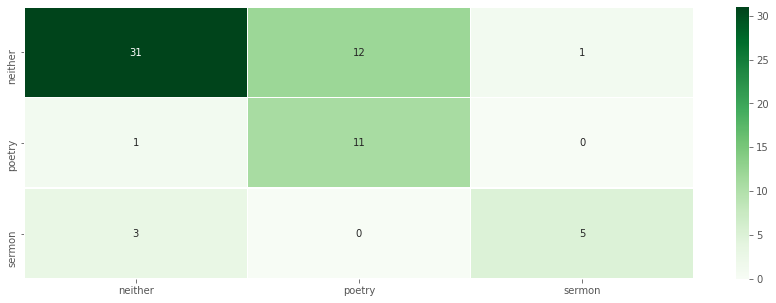

In [54]:
cm = confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm, columns=clf.classes_, index=clf.classes_)
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cm_df,annot=True,cmap='Greens',linewidths=.5)

In this confusion matrix, predicted values (the output of the model) are shown horizontally and expected values (what was in the original data) are shown vertically. When the two match, we can see the number of *true positives*, places where the predicted value matched the expected value. Those are the darkest squares along the diagonal from top left to bottom right. Our model got sermons right 5 times, poetry right 11 times, and correctly predicted when a text was neither 31 times. 

The confusion matrix also shows false results---places where the predicted value did not match the expected value. Like we saw in the list above, the model miscategorized 12 texts labeled as "neither" as poetry, for example. This could be a blind spot in our model, or it could be that we have more poetry texts in our data than we originally thought!

We need to keep in mind that this is a small corpus and the genre groups aren't symmetrical, so we should take these results with a grain of salt. If we really wanted to detect sermons, for instance, we should choose a larger sample of sermons from the *EarlyPrint* corpus and compare them to an equally-sized set of non-sermon texts.

## Interpreting Results

So we know the logistic regression model performed decently. It identifies the correct genre of a text in many cases. Now that we have the model, we could plug in a new, unfamiliar text, and the model would attempt to tell us whether it was a sermon, poetry, or something else!

Wait a second---there are no *new* early modern texts, and a literary scholar could simply read a text to determine its genre. The truth is, we don't *need* a model to tell us a text's genre, especially for something as distinct as a sermon or a poem. So if we don't need a model to predict the genre, then what is the model *for*?

For Facebook or FiveThirtyEight, models might be useful because of what they predict. But digital humanities scholars don't usually need computers to perform tasks for them, instead they're using the computer to help them to better understand their corpus. 

At the beginning of this tutorial, we started by getting the Tf-Idf scores for the words in each text. We did that because of an instinct that the vocabulary of a text is related to its genre. And based on the relative success of our model, there does seem to be such a relationship. But what's the nature of that relationship? What do wordcounts have to do with genre?

This gets back to why we used logistic regression over other approaches. As a model it's interpretable because it provides *coefficients* for each feature. That is, it doesn't just tell us the answer: logistic regression tells us how it arrived at the answer. For each possible genre class, the model gives us a coefficient for every feature, every word. The coefficient is either a positive or negative number. If the coefficient is a high positive number, that means it's a strong positive indicator that a text will belong in that class: if that word appears a lot in the text, the model will be more likely to assign the text to that genre. If the coefficient is a low negative number, that means it's a strong negative indicator: if that word appears a lot in the text, the model will be more likely **not** to assign the play to that genre.

In the code below, we'll show the top 5 highest and lowest coefficients for each class. This gives us a sense of what words drove the model's genre predictions.

In [55]:
for g,c in zip(clf.classes_, clf.coef_):
    print("Genre:", g)
    sort_values = sorted(list(zip(tfidf.get_feature_names(), c)), key = lambda x: x[1], reverse=True)
    print("Best positive indicators (words with highest coefficients):")
    for s in sort_values[:5]:
        print("\t", s)
    print("Best negative indicators (words with lowest coefficients):")
    for s in sort_values[-5:]:
        print("\t", s)
    print()

Genre: neither
Best positive indicators (words with highest coefficients):
	 ('tromp', 16.90378751994914)
	 ('six', 7.422771045694573)
	 ('burgh', 7.2036946445005094)
	 ('ratclif', 7.001642596322178)
	 ('sixty', 5.6172705361963065)
Best negative indicators (words with lowest coefficients):
	 ('666', -6.168242280327785)
	 ('diev', -6.172133762458676)
	 ('ratcliff', -6.317900079000194)
	 ('swinge', -7.02144769319718)
	 ('trump', -11.148209605246723)

Genre: poetry
Best positive indicators (words with highest coefficients):
	 ('trump', 12.03375401826274)
	 ('swinge', 7.305917391609967)
	 ('diev', 6.751384753077631)
	 ('bill', 6.406296634187871)
	 ('666', 6.404788081993181)
Best negative indicators (words with lowest coefficients):
	 ('excellent', -5.091523054002271)
	 ('six', -5.135377706702381)
	 ('ratclif', -6.704958793367047)
	 ('burgh', -6.839978363829833)
	 ('tromp', -16.24654969995368)

Genre: sermon
Best positive indicators (words with highest coefficients):
	 ('sermon', 8.13634660

Not everything in these lists is perfectly clear, but though we'd want to do more digging, there are some interesting results. Most obviously, if a text contains the word "sermon," it's probably a sermon! But more interestingly, the words "text" and "soundness" are highly indicative of sermons, which may be because many sermons are concerned with scriptural interpretation. Likewise if a text discusses sheriffs or the Dutch, our model will assume (usually correctly) that it's not a sermon. Overall, this list conforms with some scholarly assumptions about certain genres, and it invites the curious scholar into more close reading, e.g. why does the word "excellent" tell us that a text doesn't contain poetry?

For a humanist scholar, models are less about *prediction* and more about the *features* themselves. A little knowledge about how various models work can go a long way. Using statistical modeling, we can begin to determine the relationship between certain sets of features and different historical categories and classifications. Beyond word counts, modeling allows scholars to explore all sorts of features and can be a powerful tool for framing questions for future research.